# Step 1: Import Libraries

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
import tensorflow as tf
import seaborn as sns


# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [2]:
# Setting random seeds for reproducibility
import random as ran
ran.seed(0)
np.random.seed(0)
tf.random.set_seed(0)
# Setting seaborn style for plots
sns.set_style('dark')


# Step 2: Reading Dataset

In [3]:
# Loading the Apple stock price dataset
true_df=pd.read_csv('AAPL.csv')

In [4]:
true_df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-11-18,18.749643,18.828215,18.507143,18.522499,16.238520,244944000
1,2013-11-19,18.536785,18.692142,18.498928,18.555357,16.267323,208938800
2,2013-11-20,18.543928,18.586430,18.368929,18.392857,16.124861,193916800
3,2013-11-21,18.485714,18.614643,18.345358,18.612143,16.317106,262026800
4,2013-11-22,18.554285,18.648571,18.518929,18.564285,16.275156,223725600
...,...,...,...,...,...,...,...
2511,2023-11-09,182.960007,184.119995,181.809998,182.410004,182.169998,53763500
2512,2023-11-10,183.970001,186.570007,183.529999,186.399994,186.399994,66133400
2513,2023-11-13,185.820007,186.029999,184.210007,184.800003,184.800003,43627500
2514,2023-11-14,187.699997,188.110001,186.300003,187.440002,187.440002,60108400


In [5]:
true_df = true_df.dropna()

In [6]:
true_df=true_df.drop_duplicates()

In [7]:
true_df.columns.values

array(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
      dtype=object)

In [8]:
true_df.reset_index(drop=True,inplace=True)

# Step 3:  Train & Test Definition

In [9]:
# Splitting the data into training and testing sets (90% train, 10% test)
train = true_df[:int(0.9 * len(true_df))] 
train
test = true_df.iloc[2224:,:]
# test

# Step 4:  Visuallization

array([[<Axes: title={'center': 'Open'}>,
        <Axes: title={'center': 'High'}>],
       [<Axes: title={'center': 'Low'}>,
        <Axes: title={'center': 'Close'}>],
       [<Axes: title={'center': 'Adj Close'}>,
        <Axes: title={'center': 'Volume'}>]], dtype=object)

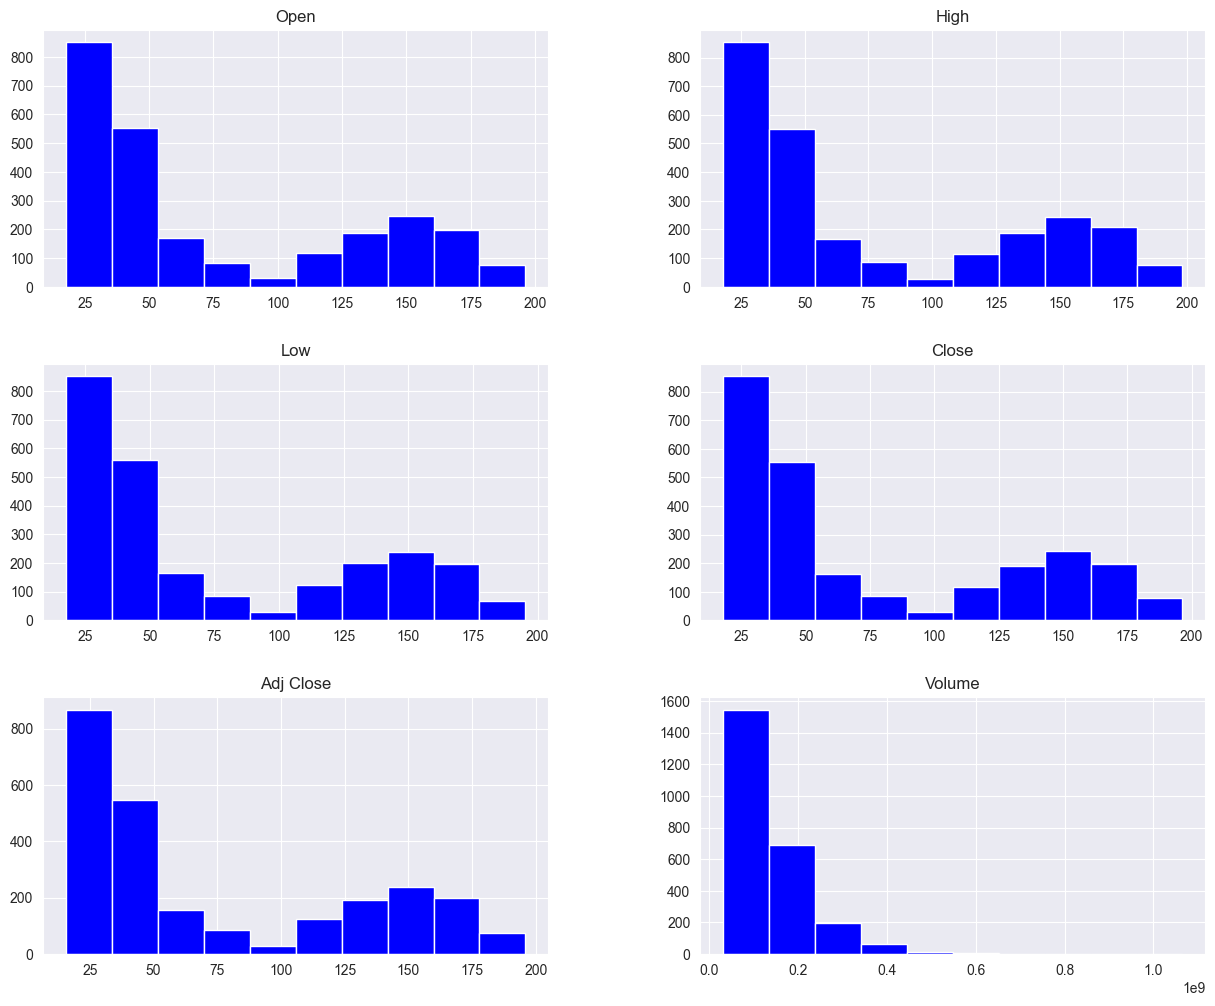

In [10]:
true_df.hist(figsize=(15,12),color='blue')

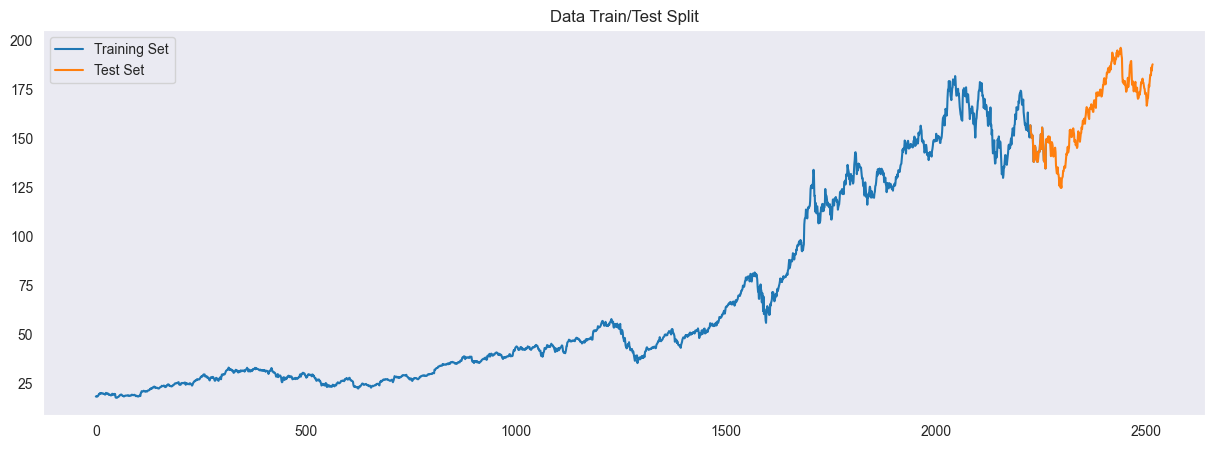

In [11]:
# Plotting the training and test sets for visualization
fig, ax = plt.subplots(figsize=(15, 5))
train.Close.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.Close.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show();

# Step 5:  Creating Model

## I wanna predict the *close* feature

In [12]:
# Selecting the 'Close' price column for training
close_train= train.iloc[:, 4:5].values 
close_train

array([[ 18.522499],
       [ 18.555357],
       [ 18.392857],
       ...,
       [146.869995],
       [149.699997],
       [148.279999]])

In [13]:
# Applying Min-Max scaling to normalize the data between -1 and 1
normalizer = MinMaxScaler(feature_range=(-1,1))

train_set_scaled= normalizer.fit_transform(close_train) 

In [14]:
train_set_scaled

array([[-0.99179811],
       [-0.9913978 ],
       [-0.99337756],
       ...,
       [ 0.57188294],
       [ 0.60636138],
       [ 0.58906128]])

##  Here i used from sliding window for validation

In [15]:
# Creating data structures with 60 timesteps and 1 output
x_train= []
y_train = []
 
for i in range(60, len(train)): 
    x_train.append(train_set_scaled[i-60:i, 0])  # 60 previous days' stock prices
    y_train.append(train_set_scaled[i, 0])   # next day's stock price

# Converting lists to numpy arrays and reshaping for LSTM input
x_train, y_train= np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) 


## RNN Model

In [16]:
# RNN Model Building
rnn_regressor = Sequential()

# Adding the first RNN layer with dropout regularization
# 'return_sequences' is True for stacking RNN layers
rnn_regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True, input_shape = (x_train.shape[1], 1)))
rnn_regressor.add(Dropout(0.2))  # Dropout to prevent overfitting

# Adding the second RNN layer and dropout regularization
rnn_regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
rnn_regressor.add(Dropout(0.2))

# Adding the third RNN layer and dropout regularization
rnn_regressor.add(SimpleRNN(units = 50, activation = "tanh", return_sequences = True))
rnn_regressor.add(Dropout(0.2))

# Adding the fourth RNN layer
rnn_regressor.add(SimpleRNN(units = 50))
rnn_regressor.add(Dropout(0.2))

# Adding the output layer
rnn_regressor.add(Dense(units = 1))

# Compiling the RNN
# Using Adam optimizer and mean squared error as loss function
rnn_regressor.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["accuracy"])

# Fitting the RNN to the training set
rnn_history = rnn_regressor.fit(x_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
69/69 [==============================] - 5s 33ms/step - loss: 0.3876 - accuracy: 4.5372e-04
Epoch 2/100
69/69 [==============================] - 2s 35ms/step - loss: 0.2263 - accuracy: 4.5372e-04
Epoch 3/100
69/69 [==============================] - 2s 33ms/step - loss: 0.1551 - accuracy: 4.5372e-04
Epoch 4/100
69/69 [==============================] - 3s 36ms/step - loss: 0.1159 - accuracy: 4.5372e-04
Epoch 5/100
69/69 [==============================] - 2s 33ms/step - loss: 0.0799 - accuracy: 4.5372e-04
Epoch 6/100
69/69 [==============================] - 2s 33ms/step - loss: 0.0677 - accuracy: 4.5372e-04
Epoch 7/100
69/69 [==============================] - 2s 33ms/step - loss: 0.0521 - accuracy: 4.5372e-04
Epoch 8/100
69/69 [==============================] - 2s 33ms/step - loss: 0.0450 - accuracy: 4.5372e-04
Epoch 9/100
69/69 [==============================] - 2s 34ms/step - loss: 0.0357 - accuracy: 4.5372e-04
Epoch 10/100
69/69 [==============================] - 2s 33ms/st

In [17]:
# Preparing the test set for predictions
rnn_price_test = test.iloc[:, 4:5].values  

In [18]:
close_train.shape

(2264, 1)

In [19]:
totality = pd.concat((pd.DataFrame(close_train), test['Close']), axis = 0)
totality.reset_index(drop=True,inplace=True)
len(totality)   

2556

In [20]:
inputs = totality[len(totality) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)

In [21]:
inputs = normalizer.transform(inputs)
len(inputs)

352

In [22]:
# Reshaping test data for LSTM input
x_test = []
y_test=[]
for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0]) 


    y_test.append(inputs[i, 0])   

x_test, y_test= np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [23]:
print('X_train Shape: ', x_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', x_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2204, 60, 1)
y_train Shape:  (2204,)
X_test Shape:   (292, 60, 1)
y_test Shape:   (292,)


In [24]:
rnn_predicted_price= rnn_regressor.predict(x_test)
rnn_predicted_price = normalizer.inverse_transform(rnn_predicted_price) 

10/10 [==============================] - 1s 10ms/step


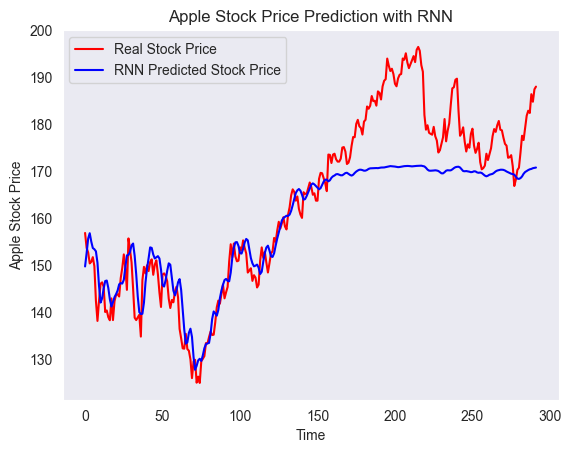

In [25]:
# Plotting the real vs predicted stock prices for RNN
plt.plot(rnn_price_test, color = 'red', label = 'Real Stock Price')
plt.plot(rnn_predicted_price, color = 'blue', label = 'RNN Predicted Stock Price')
plt.title('Apple Stock Price Prediction with RNN')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [34]:
# Evaluating the RNN model using R2 score and loss results
rnn_r2_score = r2_score(rnn_price_test[0:len(test)], rnn_predicted_price)
rnn_r2_score

0.7622417589534782

In [27]:
rnn_result = rnn_regressor.evaluate(x_test, y_test)

10/10 [==============================] - 1s 11ms/step - loss: 0.0121 - accuracy: 0.0000e+00


## LSTM Model

In [28]:
# LSTM Model Building
regressor = Sequential() 

regressor.add(LSTM(units = 256, return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.1))  

# Adding more LSTM and Dropout layers
regressor.add(LSTM(units = 128, return_sequences = True))
regressor.add(Dropout(0.1))  

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.1))

# Output layer with single unit for prediction              
regressor.add(Dense(units = 1, activation = 'selu'))

# Compiling the LSTM model
regressor.compile(optimizer = 'nadam', loss = 'mean_squared_error',metrics = ['mean_absolute_error'])

# Fitting the LSTM model to the training set
regressor.fit(x_train, y_train, epochs = 100, batch_size = 32) 

Epoch 1/100
69/69 [==============================] - 23s 219ms/step - loss: 0.0191 - mean_absolute_error: 0.0858
Epoch 2/100
69/69 [==============================] - 15s 219ms/step - loss: 0.0049 - mean_absolute_error: 0.0530
Epoch 3/100
69/69 [==============================] - 15s 218ms/step - loss: 0.0040 - mean_absolute_error: 0.0471
Epoch 4/100
69/69 [==============================] - 15s 217ms/step - loss: 0.0040 - mean_absolute_error: 0.0478
Epoch 5/100
69/69 [==============================] - 15s 218ms/step - loss: 0.0039 - mean_absolute_error: 0.0464
Epoch 6/100
69/69 [==============================] - 15s 221ms/step - loss: 0.0035 - mean_absolute_error: 0.0446
Epoch 7/100
69/69 [==============================] - 15s 218ms/step - loss: 0.0033 - mean_absolute_error: 0.0425
Epoch 8/100
69/69 [==============================] - 15s 221ms/step - loss: 0.0031 - mean_absolute_error: 0.0411
Epoch 9/100
69/69 [==============================] - 15s 217ms/step - loss: 0.0030 - mean_absolu

In [29]:
# Preparing the test set for predictions
price_test = test.iloc[:, 4:5].values  

In [30]:
predicted_price= regressor.predict(x_test)
predicted_price = normalizer.inverse_transform(predicted_price) 

10/10 [==============================] - 2s 73ms/step


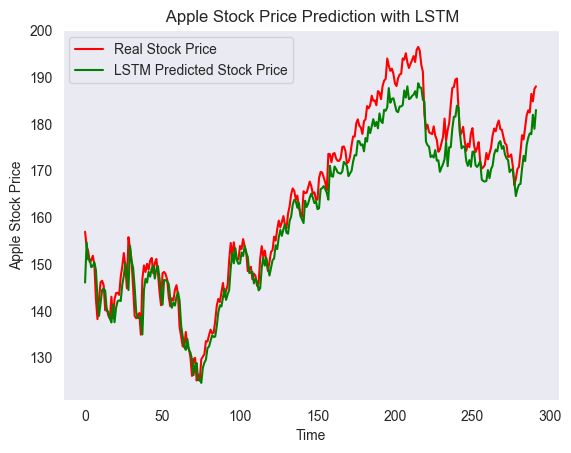

In [31]:
# Plotting the real vs predicted stock prices for LSTM
plt.plot(price_test, color = 'red', label = 'Real Stock Price')
plt.plot(predicted_price, color = 'green', label = 'LSTM Predicted Stock Price')
plt.title(' Apple Stock Price Prediction with LSTM')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

In [32]:
# Evaluating the model using R2 score
r2_score(price_test[0:len(test)],predicted_price)

0.9441088855320526

In [33]:
# Evaluating the model using the test data
result =regressor.evaluate(x_test, y_test)

10/10 [==============================] - 2s 73ms/step - loss: 0.0029 - mean_absolute_error: 0.0442
